In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
def res_block(x, filters, kernel_size=3, stride=1, use_shortcut=False):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if use_shortcut:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape=(224, 224, 3), is_50=False):
    filters = [64, 128, 256, 512]
    repetitions = [3, 4, 6, 3] if not is_50 else [3, 4, 6, 3]  # 기본적으로 ResNet-34 구조를 위한 레이어 반복 수

    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for i, rep in enumerate(repetitions):
        for j in range(rep):
            if j == 0 and i > 0:
                x = res_block(x, filters[i], stride=2, use_shortcut=True)
            else:
                x = res_block(x, filters[i])
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs, name='resnet34' if not is_50 else 'resnet50')
    return model

In [3]:
# 모델 빌드
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)
resnet_34.summary()

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [4]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True)
resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
___________________________________________________________________________________________

## Plainnet 구조 만들기

In [5]:
def plain_block(x, filters, kernel_size=3, stride=1):
    """Skip connection이 없는 Plain block"""
    # 첫 번째 Conv 레이어
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 두 번째 Conv 레이어
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [6]:
def build_plainnet(input_shape=(224, 224, 3), num_layers=34):
    """PlainNet-34 또는 PlainNet-50 모델을 빌드"""
    if num_layers == 34:
        filters = [64, 128, 256, 512]
        repetitions = [3, 4, 6, 3]  # PlainNet-34
    elif num_layers == 50:
        filters = [64, 128, 256, 512]
        repetitions = [3, 4, 6, 3]  # PlainNet-50, 동일한 구조로 블록을 사용

    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for i, rep in enumerate(repetitions):
        for j in range(rep):
            if j == 0 and i > 0:
                x = plain_block(x, filters[i], stride=2)  # 다운샘플링이 필요한 경우 stride=2
            else:
                x = plain_block(x, filters[i])

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1000, activation='softmax')(x)

    model_name = f"plainnet{num_layers}"
    model = Model(inputs, outputs, name=model_name)
    return model

In [7]:
# PlainNet-34 모델
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), num_layers=34)
plainnet_34.summary()

Model: "plainnet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_72 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_66 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_73 (Batc (None, 56, 56, 64)        2

In [8]:
# PlainNet-50 모델
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), num_layers=50)
plainnet_50.summary()

Model: "plainnet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_105 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_99 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_106 (Bat (None, 56, 56, 64)        2

## cats_vs_dogs 데이터 셋 가져오기

In [9]:
# 새 링크로 URL 수정
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 배치 크기 설정
BATCH_SIZE = 256

# 이미지 리사이즈와 정규화 전처리 함수 (224x224로 리사이즈)
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 224x224로 리사이즈
    image = tf.cast(image, tf.float32) / 255.0  # [0, 1] 범위로 정규화
    return image, label

# 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # 학습 및 검증용 데이터 분리
    as_supervised=True,
    shuffle_files=True,  # 파일을 셔플
    with_info=True,
)

# 전처리 적용 및 배치 크기 설정
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 데이터셋 정보 출력 (선택 사항)
print(ds_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    t

In [10]:
# SGD 옵티마이저와 clipnorm 설정
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.0)

# ResNet-34 컴파일
resnet_34.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# PlainNet-34 컴파일
plainnet_34.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# ResNet-34 학습
history_resnet = resnet_34.fit(ds_train, epochs=10, validation_data=ds_test)

# PlainNet-34 학습
history_plainnet = plainnet_34.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/10
20/73 [=======>......................] - ETA: 1:05 - loss: 1.6452 - accuracy: 0.4395

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:00 - loss: 1.4973 - accuracy: 0.4616

26/73 [=========>....................] - ETA: 57s - loss: 1.4414 - accuracy: 0.4703

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 1.2523 - accuracy: 0.5037

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 1.0075 - accuracy: 0.5524

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 1.0017 - accuracy: 0.5537

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.9978 - accuracy: 0.5548

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.9769 - accuracy: 0.5599

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.9718 - accuracy: 0.5609

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.9508 - accuracy: 0.5645

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 122s 1s/step - loss: 0.9508 - accuracy: 0.5645 - val_loss: 0.9670 - val_accuracy: 0.4901
Epoch 2/10
20/73 [=======>......................] - ETA: 1:06 - loss: 0.6441 - accuracy: 0.6381

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.6442 - accuracy: 0.6356

26/73 [=========>....................] - ETA: 59s - loss: 0.6451 - accuracy: 0.6364 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6413 - accuracy: 0.6367

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


60/73 [=======================>......] - ETA: 16s - loss: 0.6358 - accuracy: 0.6416

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6338 - accuracy: 0.6430

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6338 - accuracy: 0.6436

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6322 - accuracy: 0.6459

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6315 - accuracy: 0.6463

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.6477

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6294 - accuracy: 0.6477 - val_loss: 0.7769 - val_accuracy: 0.4901
Epoch 3/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.5973 - accuracy: 0.6855

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.5985 - accuracy: 0.6834

26/73 [=========>....................] - ETA: 59s - loss: 0.6005 - accuracy: 0.6809 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.5964 - accuracy: 0.6806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5874 - accuracy: 0.6870

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.5875 - accuracy: 0.6876

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5875 - accuracy: 0.6880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5867 - accuracy: 0.6892

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5859 - accuracy: 0.6900

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.6920

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.5842 - accuracy: 0.6920 - val_loss: 0.7594 - val_accuracy: 0.4901
Epoch 4/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.5614 - accuracy: 0.7163

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.5606 - accuracy: 0.7156

26/73 [=========>....................] - ETA: 59s - loss: 0.5634 - accuracy: 0.7141 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.5585 - accuracy: 0.7157

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5485 - accuracy: 0.7225

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.5475 - accuracy: 0.7235

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5472 - accuracy: 0.7237

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5455 - accuracy: 0.7248

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5452 - accuracy: 0.7249

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.7247

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.5458 - accuracy: 0.7247 - val_loss: 0.7822 - val_accuracy: 0.4938
Epoch 5/10
21/73 [=======>......................] - ETA: 1:04 - loss: 0.5117 - accuracy: 0.7541

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 59s - loss: 0.5128 - accuracy: 0.7503 

26/73 [=========>....................] - ETA: 58s - loss: 0.5136 - accuracy: 0.7497

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.5101 - accuracy: 0.7509

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5071 - accuracy: 0.7524

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.5064 - accuracy: 0.7535

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5066 - accuracy: 0.7534

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5060 - accuracy: 0.7539

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5048 - accuracy: 0.7550

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7552

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.5042 - accuracy: 0.7552 - val_loss: 0.8463 - val_accuracy: 0.4925
Epoch 6/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.4832 - accuracy: 0.7621

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.4822 - accuracy: 0.7617

26/73 [=========>....................] - ETA: 59s - loss: 0.4834 - accuracy: 0.7602 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.4792 - accuracy: 0.7650

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.4731 - accuracy: 0.7713

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.4723 - accuracy: 0.7723

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.4728 - accuracy: 0.7725

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.4723 - accuracy: 0.7724

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.4720 - accuracy: 0.7725

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.7729

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.4718 - accuracy: 0.7729 - val_loss: 0.9223 - val_accuracy: 0.5039
Epoch 7/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.4401 - accuracy: 0.7939

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.4389 - accuracy: 0.7949

26/73 [=========>....................] - ETA: 59s - loss: 0.4392 - accuracy: 0.7940 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.4369 - accuracy: 0.7941

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.4337 - accuracy: 0.7962

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.4331 - accuracy: 0.7966

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.4328 - accuracy: 0.7965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.4317 - accuracy: 0.7976

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.7978

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.4312 - accuracy: 0.7978 - val_loss: 0.8835 - val_accuracy: 0.5737
Epoch 8/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.4014 - accuracy: 0.8179

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.3984 - accuracy: 0.8191

26/73 [=========>....................] - ETA: 59s - loss: 0.4004 - accuracy: 0.8173 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.3945 - accuracy: 0.8220

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.3934 - accuracy: 0.8240

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.3925 - accuracy: 0.8246

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.3931 - accuracy: 0.8243

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.3916 - accuracy: 0.8243

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.3911 - accuracy: 0.8246

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.3891 - accuracy: 0.8250 - val_loss: 0.7726 - val_accuracy: 0.6359
Epoch 9/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.3576 - accuracy: 0.8464

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.3543 - accuracy: 0.8467

26/73 [=========>....................] - ETA: 59s - loss: 0.3590 - accuracy: 0.8434 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.3500 - accuracy: 0.8479

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


60/73 [=======================>......] - ETA: 16s - loss: 0.3462 - accuracy: 0.8488

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.3448 - accuracy: 0.8492

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.3451 - accuracy: 0.8491

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.3448 - accuracy: 0.8492

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.3448 - accuracy: 0.8491

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8498

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 103s 1s/step - loss: 0.3427 - accuracy: 0.8498 - val_loss: 0.6697 - val_accuracy: 0.7126
Epoch 10/10
21/73 [=======>......................] - ETA: 1:04 - loss: 0.2979 - accuracy: 0.8692

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 59s - loss: 0.2940 - accuracy: 0.8720 

26/73 [=========>....................] - ETA: 58s - loss: 0.2948 - accuracy: 0.8714

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.2928 - accuracy: 0.8724

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.2869 - accuracy: 0.8772

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.2873 - accuracy: 0.8774

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.2869 - accuracy: 0.8777

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.2851 - accuracy: 0.8783

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.8797

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.2822 - accuracy: 0.8797 - val_loss: 2.5580 - val_accuracy: 0.5120
Epoch 1/10
21/73 [=======>......................] - ETA: 1:02 - loss: 6.2967 - accuracy: 0.3408

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 58s - loss: 6.1703 - accuracy: 0.3608

26/73 [=========>....................] - ETA: 56s - loss: 6.0831 - accuracy: 0.3739

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 5.7077 - accuracy: 0.4095

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 4.7443 - accuracy: 0.4550

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 4.6760 - accuracy: 0.4582

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 4.6434 - accuracy: 0.4581

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 4.5445 - accuracy: 0.4608

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 4.5114 - accuracy: 0.4625

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 4.3591 - accuracy: 0.4661

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 4.3591 - accuracy: 0.4661 - val_loss: 5.8913 - val_accuracy: 0.4901
Epoch 2/10
21/73 [=======>......................] - ETA: 1:02 - loss: 1.6098 - accuracy: 0.5277

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 1.5443 - accuracy: 0.5305

26/73 [=========>....................] - ETA: 56s - loss: 1.5288 - accuracy: 0.5296

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 1.4045 - accuracy: 0.5357

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 1.1696 - accuracy: 0.5485

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 1.1633 - accuracy: 0.5488

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 1.1513 - accuracy: 0.5490

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 1.1340 - accuracy: 0.5502

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 1.1283 - accuracy: 0.5514

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 1.1049 - accuracy: 0.5507

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 1.1049 - accuracy: 0.5507 - val_loss: 3.7653 - val_accuracy: 0.4901
Epoch 3/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.7403 - accuracy: 0.5653

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.7372 - accuracy: 0.5702

26/73 [=========>....................] - ETA: 56s - loss: 0.7372 - accuracy: 0.5696

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.7336 - accuracy: 0.5670

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.7265 - accuracy: 0.5649

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.7261 - accuracy: 0.5649

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.7260 - accuracy: 0.5649

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.7254 - accuracy: 0.5645

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.7252 - accuracy: 0.5643

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.5619

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.7247 - accuracy: 0.5619 - val_loss: 1.7824 - val_accuracy: 0.4901
Epoch 4/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.7043 - accuracy: 0.5709

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.7026 - accuracy: 0.5753

26/73 [=========>....................] - ETA: 56s - loss: 0.7028 - accuracy: 0.5753

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.7011 - accuracy: 0.5740

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6973 - accuracy: 0.5779

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6971 - accuracy: 0.5785

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6967 - accuracy: 0.5793

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6960 - accuracy: 0.5804

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.5798

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6960 - accuracy: 0.5798 - val_loss: 1.0842 - val_accuracy: 0.4901
Epoch 5/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6857 - accuracy: 0.5861

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.6843 - accuracy: 0.5892

26/73 [=========>....................] - ETA: 56s - loss: 0.6853 - accuracy: 0.5870

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6847 - accuracy: 0.5906

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6822 - accuracy: 0.5937

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6822 - accuracy: 0.5937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6820 - accuracy: 0.5934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6816 - accuracy: 0.5948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6816 - accuracy: 0.5950

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.5943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 98s 1s/step - loss: 0.6813 - accuracy: 0.5943 - val_loss: 1.0558 - val_accuracy: 0.4901
Epoch 6/10
21/73 [=======>......................] - ETA: 1:01 - loss: 0.6740 - accuracy: 0.6044

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 56s - loss: 0.6732 - accuracy: 0.6056

26/73 [=========>....................] - ETA: 55s - loss: 0.6739 - accuracy: 0.6038

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6736 - accuracy: 0.6066

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6697 - accuracy: 0.6112

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6697 - accuracy: 0.6110

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6694 - accuracy: 0.6115

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6691 - accuracy: 0.6118

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6684 - accuracy: 0.6126

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.6142

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6682 - accuracy: 0.6142 - val_loss: 1.0822 - val_accuracy: 0.4895
Epoch 7/10
21/73 [=======>......................] - ETA: 1:01 - loss: 0.6594 - accuracy: 0.6190

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 57s - loss: 0.6586 - accuracy: 0.6201

26/73 [=========>....................] - ETA: 55s - loss: 0.6586 - accuracy: 0.6217

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6588 - accuracy: 0.6220

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6539 - accuracy: 0.6279

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6537 - accuracy: 0.6282

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6534 - accuracy: 0.6288

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6528 - accuracy: 0.6296

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6522 - accuracy: 0.6301

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.6315

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6517 - accuracy: 0.6315 - val_loss: 0.6796 - val_accuracy: 0.5954
Epoch 8/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6449 - accuracy: 0.6336

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.6436 - accuracy: 0.6350

26/73 [=========>....................] - ETA: 56s - loss: 0.6441 - accuracy: 0.6337

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6445 - accuracy: 0.6315

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6383 - accuracy: 0.6408

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6384 - accuracy: 0.6409

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6382 - accuracy: 0.6414

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6375 - accuracy: 0.6411

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6418

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6378 - accuracy: 0.6418 - val_loss: 0.7304 - val_accuracy: 0.5699
Epoch 9/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6371 - accuracy: 0.6442

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.6343 - accuracy: 0.6472

26/73 [=========>....................] - ETA: 56s - loss: 0.6352 - accuracy: 0.6465

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6344 - accuracy: 0.6462

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6306 - accuracy: 0.6475

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6301 - accuracy: 0.6481

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6297 - accuracy: 0.6487

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6291 - accuracy: 0.6498

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6282 - accuracy: 0.6506

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.6497

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6288 - accuracy: 0.6497 - val_loss: 0.7205 - val_accuracy: 0.5460
Epoch 10/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6237 - accuracy: 0.6600

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.6234 - accuracy: 0.6591

26/73 [=========>....................] - ETA: 56s - loss: 0.6245 - accuracy: 0.6573

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6235 - accuracy: 0.6573

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6200 - accuracy: 0.6620

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6196 - accuracy: 0.6621

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6197 - accuracy: 0.6617

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6188 - accuracy: 0.6624

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6180 - accuracy: 0.6627

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.6620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6191 - accuracy: 0.6620 - val_loss: 0.6530 - val_accuracy: 0.6122


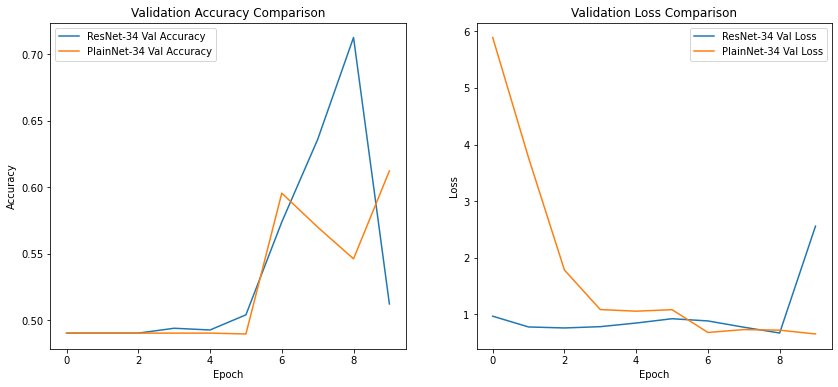

In [12]:
# 학습 결과 시각화
def plot_history(history1, history2, title1='ResNet-34', title2='PlainNet-34'):
    # 검증 정확도 비교
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_accuracy'], label=title1 + ' Val Accuracy')
    plt.plot(history2.history['val_accuracy'], label=title2 + ' Val Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 검증 손실 비교
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_loss'], label=title1 + ' Val Loss')
    plt.plot(history2.history['val_loss'], label=title2 + ' Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 시각화 호출
plot_history(history_resnet, history_plainnet)


In [13]:
# ResNet-34 컴파일
resnet_50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# PlainNet-34 컴파일
plainnet_50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# ResNet-50 학습
history_resnet_50 = resnet_50.fit(ds_train, epochs=10, validation_data=ds_test)

# PlainNet-50 학습
history_plainnet_50 = plainnet_50.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/10
21/73 [=======>......................] - ETA: 1:04 - loss: 0.9881 - accuracy: 0.5249

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:00 - loss: 0.9529 - accuracy: 0.5334

26/73 [=========>....................] - ETA: 58s - loss: 0.9353 - accuracy: 0.5356

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.8708 - accuracy: 0.5531

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.7774 - accuracy: 0.5914

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.7748 - accuracy: 0.5929

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.7729 - accuracy: 0.5934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.7641 - accuracy: 0.5970

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.7620 - accuracy: 0.5976

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.7546 - accuracy: 0.6004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.7546 - accuracy: 0.6004 - val_loss: 1.0486 - val_accuracy: 0.4901
Epoch 2/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6377 - accuracy: 0.6458

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6325 - accuracy: 0.6494

26/73 [=========>....................] - ETA: 59s - loss: 0.6342 - accuracy: 0.6478 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6347 - accuracy: 0.6493

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6252 - accuracy: 0.6591

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6246 - accuracy: 0.6594

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6244 - accuracy: 0.6596

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6225 - accuracy: 0.6616

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.6619

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6226 - accuracy: 0.6619 - val_loss: 1.0943 - val_accuracy: 0.4901
Epoch 3/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6001 - accuracy: 0.6802

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.5976 - accuracy: 0.6814

26/73 [=========>....................] - ETA: 59s - loss: 0.5997 - accuracy: 0.6789 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.5994 - accuracy: 0.6806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5898 - accuracy: 0.6871

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.5901 - accuracy: 0.6873

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5903 - accuracy: 0.6873

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5906 - accuracy: 0.6876

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5896 - accuracy: 0.6882

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.6879

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.5889 - accuracy: 0.6879 - val_loss: 1.2368 - val_accuracy: 0.4901
Epoch 4/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.5696 - accuracy: 0.7037

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.5688 - accuracy: 0.7021

26/73 [=========>....................] - ETA: 59s - loss: 0.5703 - accuracy: 0.7015 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.5704 - accuracy: 0.7007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5610 - accuracy: 0.7093

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.5605 - accuracy: 0.7096

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5601 - accuracy: 0.7100

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5587 - accuracy: 0.7111

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5575 - accuracy: 0.7123

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.7121

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.5570 - accuracy: 0.7121 - val_loss: 1.0108 - val_accuracy: 0.4916
Epoch 5/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.5405 - accuracy: 0.7290

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.5406 - accuracy: 0.7277

26/73 [=========>....................] - ETA: 59s - loss: 0.5423 - accuracy: 0.7258 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.5384 - accuracy: 0.7282

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5283 - accuracy: 0.7348

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.5270 - accuracy: 0.7355

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5270 - accuracy: 0.7354

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5250 - accuracy: 0.7366

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5242 - accuracy: 0.7375

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.7385

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.5234 - accuracy: 0.7385 - val_loss: 1.0287 - val_accuracy: 0.4871
Epoch 6/10
21/73 [=======>......................] - ETA: 1:04 - loss: 0.4983 - accuracy: 0.7647

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 59s - loss: 0.5011 - accuracy: 0.7642 

26/73 [=========>....................] - ETA: 58s - loss: 0.5023 - accuracy: 0.7625

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.4996 - accuracy: 0.7627

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.4928 - accuracy: 0.7640

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.4916 - accuracy: 0.7649

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.4913 - accuracy: 0.7652

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.4894 - accuracy: 0.7660

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.4884 - accuracy: 0.7663

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7674

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.4871 - accuracy: 0.7674 - val_loss: 0.8120 - val_accuracy: 0.5800
Epoch 7/10
21/73 [=======>......................] - ETA: 1:04 - loss: 0.4593 - accuracy: 0.7818

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 59s - loss: 0.4637 - accuracy: 0.7781 

26/73 [=========>....................] - ETA: 58s - loss: 0.4645 - accuracy: 0.7764

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.4614 - accuracy: 0.7789

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.4558 - accuracy: 0.7830

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.4541 - accuracy: 0.7845

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.4541 - accuracy: 0.7847

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.4525 - accuracy: 0.7858

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.4516 - accuracy: 0.7862

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.7873

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.4498 - accuracy: 0.7873 - val_loss: 0.7146 - val_accuracy: 0.6374
Epoch 8/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.4316 - accuracy: 0.8019

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.4310 - accuracy: 0.8009

26/73 [=========>....................] - ETA: 59s - loss: 0.4309 - accuracy: 0.8003 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.4265 - accuracy: 0.8049

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.4208 - accuracy: 0.8065

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.4205 - accuracy: 0.8070

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.4190 - accuracy: 0.8083

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.4164 - accuracy: 0.8095

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.4152 - accuracy: 0.8101

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8109

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 102s 1s/step - loss: 0.4134 - accuracy: 0.8109 - val_loss: 0.9592 - val_accuracy: 0.6111
Epoch 9/10
21/73 [=======>......................] - ETA: 1:05 - loss: 0.3816 - accuracy: 0.8305

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.3874 - accuracy: 0.8259

26/73 [=========>....................] - ETA: 59s - loss: 0.3869 - accuracy: 0.8257 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.3815 - accuracy: 0.8299

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.3737 - accuracy: 0.8353

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.3723 - accuracy: 0.8358

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.3730 - accuracy: 0.8353

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.3717 - accuracy: 0.8358

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.3708 - accuracy: 0.8362

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8370

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.3694 - accuracy: 0.8370 - val_loss: 0.5389 - val_accuracy: 0.7489
Epoch 10/10
21/73 [=======>......................] - ETA: 1:04 - loss: 0.3292 - accuracy: 0.8570

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:00 - loss: 0.3361 - accuracy: 0.8522

25/73 [=========>....................] - ETA: 59s - loss: 0.3348 - accuracy: 0.8527 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.3319 - accuracy: 0.8560

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


60/73 [=======================>......] - ETA: 16s - loss: 0.3204 - accuracy: 0.8634

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.3196 - accuracy: 0.8638

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.3188 - accuracy: 0.8640

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.3171 - accuracy: 0.8649

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.3166 - accuracy: 0.8651

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8678

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.3127 - accuracy: 0.8678 - val_loss: 0.7936 - val_accuracy: 0.6838
Epoch 1/10
21/73 [=======>......................] - ETA: 1:02 - loss: 6.2314 - accuracy: 0.3025

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 6.0622 - accuracy: 0.3434

26/73 [=========>....................] - ETA: 56s - loss: 6.0182 - accuracy: 0.3510

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 5.6579 - accuracy: 0.3998

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 4.6793 - accuracy: 0.4600

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 4.6097 - accuracy: 0.4630

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 4.5758 - accuracy: 0.4644

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 4.4408 - accuracy: 0.4695

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 4.2856 - accuracy: 0.4754

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 4.2856 - accuracy: 0.4754 - val_loss: 5.7709 - val_accuracy: 0.4901
Epoch 2/10
21/73 [=======>......................] - ETA: 1:02 - loss: 1.5083 - accuracy: 0.5588

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 59s - loss: 1.4625 - accuracy: 0.5612 

26/73 [=========>....................] - ETA: 56s - loss: 1.4335 - accuracy: 0.5605

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 1.3193 - accuracy: 0.5584

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 1.1089 - accuracy: 0.5619

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 1.0982 - accuracy: 0.5621

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 1.0929 - accuracy: 0.5624

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 1.0775 - accuracy: 0.5633

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 1.0728 - accuracy: 0.5636

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 1.0518 - accuracy: 0.5631

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 1.0518 - accuracy: 0.5631 - val_loss: 3.3474 - val_accuracy: 0.4901
Epoch 3/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.7309 - accuracy: 0.5787

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 58s - loss: 0.7294 - accuracy: 0.5798 

26/73 [=========>....................] - ETA: 56s - loss: 0.7285 - accuracy: 0.5786

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.7253 - accuracy: 0.5780

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.7160 - accuracy: 0.5802

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.7152 - accuracy: 0.5808

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.7148 - accuracy: 0.5811

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.7135 - accuracy: 0.5826

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.7130 - accuracy: 0.5827

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.5823

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.7120 - accuracy: 0.5823 - val_loss: 1.5224 - val_accuracy: 0.4901
Epoch 4/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6940 - accuracy: 0.5848

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.6940 - accuracy: 0.5873

26/73 [=========>....................] - ETA: 56s - loss: 0.6940 - accuracy: 0.5862

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6941 - accuracy: 0.5866

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6919 - accuracy: 0.5887

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6913 - accuracy: 0.5899

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6911 - accuracy: 0.5901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6899 - accuracy: 0.5917

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6895 - accuracy: 0.5923

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5916

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6889 - accuracy: 0.5916 - val_loss: 1.1743 - val_accuracy: 0.4901
Epoch 5/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6809 - accuracy: 0.5936

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 58s - loss: 0.6798 - accuracy: 0.5975 

26/73 [=========>....................] - ETA: 56s - loss: 0.6788 - accuracy: 0.5987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6796 - accuracy: 0.5979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6755 - accuracy: 0.6007

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6751 - accuracy: 0.6011

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6749 - accuracy: 0.6014

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6740 - accuracy: 0.6025

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6735 - accuracy: 0.6030

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.6046

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6729 - accuracy: 0.6046 - val_loss: 1.0244 - val_accuracy: 0.4901
Epoch 6/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6682 - accuracy: 0.6057

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.6663 - accuracy: 0.6100

26/73 [=========>....................] - ETA: 56s - loss: 0.6663 - accuracy: 0.6107

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6659 - accuracy: 0.6089

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6616 - accuracy: 0.6137

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6614 - accuracy: 0.6140

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6612 - accuracy: 0.6144

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6597 - accuracy: 0.6168

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6178

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6593 - accuracy: 0.6178 - val_loss: 0.8040 - val_accuracy: 0.5030
Epoch 7/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6529 - accuracy: 0.6295

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.6498 - accuracy: 0.6333

26/73 [=========>....................] - ETA: 56s - loss: 0.6506 - accuracy: 0.6309

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6524 - accuracy: 0.6241

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6486 - accuracy: 0.6235

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6480 - accuracy: 0.6239

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6482 - accuracy: 0.6240

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6469 - accuracy: 0.6255

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6272

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6461 - accuracy: 0.6272 - val_loss: 0.7046 - val_accuracy: 0.5707
Epoch 8/10
21/73 [=======>......................] - ETA: 1:01 - loss: 0.6374 - accuracy: 0.6451

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 56s - loss: 0.6342 - accuracy: 0.6497

26/73 [=========>....................] - ETA: 55s - loss: 0.6354 - accuracy: 0.6490

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6374 - accuracy: 0.6394

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6355 - accuracy: 0.6434

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6351 - accuracy: 0.6436

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6355 - accuracy: 0.6434

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6351 - accuracy: 0.6439

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6345 - accuracy: 0.6444

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.6450

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 98s 1s/step - loss: 0.6343 - accuracy: 0.6450 - val_loss: 0.6604 - val_accuracy: 0.6040
Epoch 9/10
21/73 [=======>......................] - ETA: 1:01 - loss: 0.6378 - accuracy: 0.6443

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 56s - loss: 0.6341 - accuracy: 0.6464

26/73 [=========>....................] - ETA: 55s - loss: 0.6358 - accuracy: 0.6442

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6353 - accuracy: 0.6424

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6314 - accuracy: 0.6452

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6312 - accuracy: 0.6456

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6311 - accuracy: 0.6455

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6298 - accuracy: 0.6476

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6291 - accuracy: 0.6486

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6292 - accuracy: 0.6477

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6292 - accuracy: 0.6477 - val_loss: 0.6779 - val_accuracy: 0.5871
Epoch 10/10
21/73 [=======>......................] - ETA: 1:02 - loss: 0.6298 - accuracy: 0.6548

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 57s - loss: 0.6295 - accuracy: 0.6545

26/73 [=========>....................] - ETA: 56s - loss: 0.6305 - accuracy: 0.6528

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 45s - loss: 0.6318 - accuracy: 0.6480

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 14s - loss: 0.6319 - accuracy: 0.6473

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6316 - accuracy: 0.6474

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 10s - loss: 0.6314 - accuracy: 0.6478

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6297 - accuracy: 0.6507

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.6504

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 95s 1s/step - loss: 0.6302 - accuracy: 0.6504 - val_loss: 0.6735 - val_accuracy: 0.6006


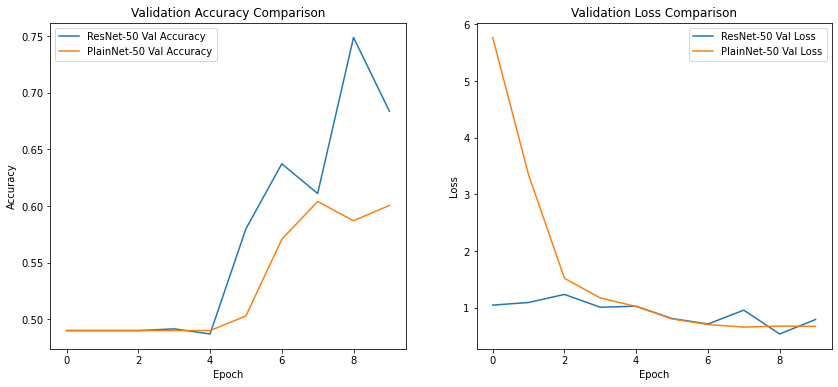

In [15]:
# 학습 결과 시각화
def plot_history_50(history1, history2, title1='ResNet-50', title2='PlainNet-50'):
    # 검증 정확도 비교
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_accuracy'], label=title1 + ' Val Accuracy')
    plt.plot(history2.history['val_accuracy'], label=title2 + ' Val Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 검증 손실 비교
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_loss'], label=title1 + ' Val Loss')
    plt.plot(history2.history['val_loss'], label=title2 + ' Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 시각화 호출
plot_history_50(history_resnet_50, history_plainnet_50)


## 오늘의 실험 결과

1. (epoch 10) ResNET 34 vs PlainNet 34 (input shape = (32, 32, 3))
    
![image.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/8e2a58d4-c9a8-40f7-862e-116e4b94e836/dca6a3c4-e835-460d-84fc-053b37c7c1b0/image.png)
    
2. (epoch 10) ResNet 50 vs plainnet 50 (input shape = (32, 32, 3))
    
![image.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/8e2a58d4-c9a8-40f7-862e-116e4b94e836/10ba3ce7-e423-4161-8a35-8159cf42e49e/image.png)
    
3. (epoch 10) ResNet 34 vs plainnet 34 (input shape = (224, 224, 3))
    
![image.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/8e2a58d4-c9a8-40f7-862e-116e4b94e836/5460940f-1ee4-4e98-b189-a4cb3a4e5638/image.png)

4. (epoch 10) ResNet 50 vs plainnet 50 (input shape = (224, 224, 3))
    
![image.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/8e2a58d4-c9a8-40f7-862e-116e4b94e836/9a3e5de9-e946-411a-84b4-63ae305eb928/image.png)


## 회고

* ### 이미지가 안열린다
* ### ResNet을 구성하는 방식과 이를 통해 이미지 데이터를 학습하는 과정까지 배워보았다.
* ### 다운로드 에러는 GPT의 도움을 받아 url 형태로 직접 다운받는 방식으로 해결하였다.
* ### 처음에는 input shape를 (32,32,3)으로 하여 실험을 진행해봤다. 확실히 빨리 끝나기도 하고 성능도 잘 나왔다.
* ### 근데 노드에 나와있는 것 처럼 (224, 224, 3)으로 하니깐 오래걸렸다.